In [1]:
# Import Library
from keras.utils import np_utils
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 18
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
from keras.utils import to_categorical
import random
from sklearn.manifold import TSNE
from keras.metrics import*
from keras.models import*
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, History, ReduceLROnPlateau, CSVLogger
# from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import datetime as dt
import h5py

%matplotlib inline


Using TensorFlow backend.


In [2]:
# Data Directory Setup
train_dir = './train/'
test_dir = './test/'

In [3]:
# Data Exploration
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
no_categories = len(categories)
print ("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print ("The number of category is {}".format(no_categories))
print ("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print ("Here are the training data intel:")
train_expl = pd.DataFrame()
sns_cat, sns_count = [], []
for cat in categories:
    sns_cat.append(cat)
    sns_count.append(len(os.listdir(os.path.join(train_dir, cat))))
    print('-{} {} images'.format(cat, len(os.listdir(os.path.join(train_dir, cat)))))

train_expl['sns_cat'] = sns_cat 
train_expl['sns_count'] = sns_count

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The number of category is 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Here are the training data intel:
-Black-grass 263 images
-Charlock 390 images
-Cleavers 287 images
-Common Chickweed 611 images
-Common wheat 221 images
-Fat Hen 475 images
-Loose Silky-bent 654 images
-Maize 221 images
-Scentless Mayweed 516 images
-Shepherds Purse 231 images
-Small-flowered Cranesbill 496 images
-Sugar beet 385 images


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

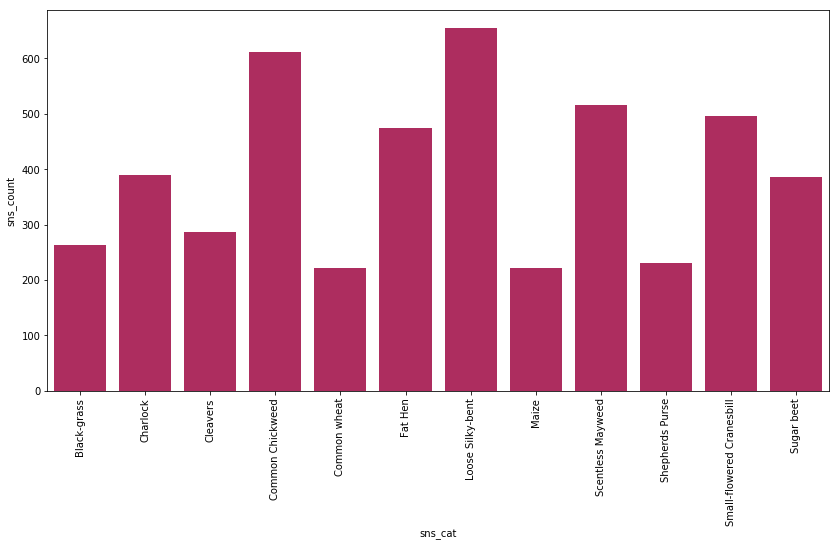

In [4]:
# Visualize Data size for different category
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(14, 7))
ax = sns.barplot(x="sns_cat", y='sns_count', color='#C2185B', data=train_expl)
plt.xticks(rotation=90)


In [5]:
# Create Training Data DataFrame
def create_training_df(train_dir, categories):
    train = []
    for cat_id, cat in enumerate(categories):
        for file in os.listdir(os.path.join(train_dir, cat)):
            if '.ipynb_checkpoints' in file:
                continue
            train.append([train_dir + '{}/{}'.format(cat, file), cat_id, cat])
    train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

    return train

In [6]:
# Show Training Data DataFrame
train_df = create_training_df(train_dir, categories)
train_df2 = train_df
train_df = train_df.drop(train_df.index[[1597, 1747, 4627]])
train_df = train_df.reset_index(drop=True)
train_df.head(10)
print ("There are {} training items".format(len(train_df)))



There are 4747 training items


In [7]:
def create_synthetic_df(categories):
    syn_train = []
    for cat_id, cat in enumerate(categories):
        for file in os.listdir(os.path.join('data_arg/', cat)):
            if '.ipynb_checkpoints' in file:
                continue
            syn_train.append(['./data_arg/{}/{}'.format(cat, file), cat_id, cat])
    syn_train = pd.DataFrame(syn_train, columns=['file', 'category_id', 'category'])

    return syn_train

syn_train_df = create_synthetic_df(categories)
syn_train_df.head(10)


,file,category_id,category
0,./data_arg/Black-grass/syn_0_9317.png,0,Black-grass
1,./data_arg/Black-grass/syn_0_177.png,0,Black-grass
2,./data_arg/Black-grass/syn_0_6602.png,0,Black-grass
3,./data_arg/Black-grass/syn_0_7579.png,0,Black-grass
4,./data_arg/Black-grass/syn_0_2119.png,0,Black-grass
5,./data_arg/Black-grass/syn_0_2973.png,0,Black-grass
6,./data_arg/Black-grass/syn_0_7468.png,0,Black-grass
7,./data_arg/Black-grass/syn_0_2776.png,0,Black-grass
8,./data_arg/Black-grass/syn_0_1258.png,0,Black-grass
9,./data_arg/Black-grass/syn_0_6744.png,0,Black-grass


In [8]:
# Create Testing Data DataFrame
def create_testing_df(test_dir):
    test = []
    for file in os.listdir(test_dir):
        if '.ipynb_checkpoints' in file:
            continue
        test.append([test_dir+file])
    test = pd.DataFrame(test, columns=['file'])

    return test

In [9]:
# Show Testing Data DataFrame
test_df = create_testing_df(test_dir)
print ("There are {} testing items".format(len(test_df)))
test_df.head(10)

There are 794 testing items


,file
0,./test/77ccb8b2a.png
1,./test/3b73c3b61.png
2,./test/dc55449b2.png
3,./test/da4ed3a28.png
4,./test/8ab8a958b.png
5,./test/e5e3dccff.png
6,./test/659412b1a.png
7,./test/e5064f6be.png
8,./test/03a2ee656.png
9,./test/ef74dbcad.png


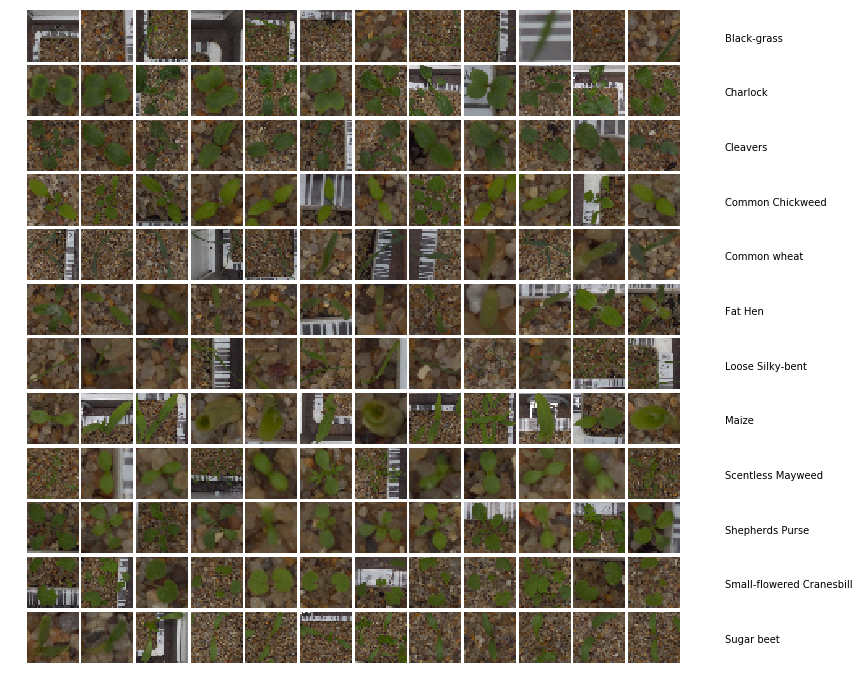

In [10]:
# Showing Image Data
# Credit to Kaggler - beluga (https://www.kaggle.com/gaborfodor/seedlings-pretrained-keras-models)
fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(no_categories, no_categories), axes_pad=0.05)
i = 0
for category_id, category in enumerate(categories):
    for filepath in train_df[train_df['category'] == category]['file'].values[:no_categories]:
        ax = grid[i]
        img = cv2.imread(filepath)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % no_categories == no_categories - 1:
            ax.text(60, 17, filepath.split('/')[2], verticalalignment='center')
        i += 1
plt.show();

In [11]:
# Data Shuffling and Splitting
# train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(10)

,file,category_id,category
0,./train/Black-grass/e47987eab.png,0,Black-grass
1,./train/Black-grass/7b72b398d.png,0,Black-grass
2,./train/Black-grass/f4b7ddbce.png,0,Black-grass
3,./train/Black-grass/6e193f1bb.png,0,Black-grass
4,./train/Black-grass/c025e2886.png,0,Black-grass
5,./train/Black-grass/686132594.png,0,Black-grass
6,./train/Black-grass/ac47ebc4d.png,0,Black-grass
7,./train/Black-grass/3a8c485bc.png,0,Black-grass
8,./train/Black-grass/957b8523c.png,0,Black-grass
9,./train/Black-grass/4a3b96198.png,0,Black-grass


In [12]:
def create_segmented_image(img):
    blurr = cv2.GaussianBlur(img,(5,5),0)
    hsv = cv2.cvtColor(blurr, cv2.COLOR_BGR2HSV)
    
    sensitivity = 30
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    masked = mask > 0
    preprocessed = np.zeros_like(img,np.uint8)
    preprocessed[masked] = img[masked]

    return np.asarray(preprocessed)


In [13]:
# Shuffling Training DataFrame
syn_train_df = syn_train_df.sample(frac=1).reset_index(drop=True)

# Mixing Original Data and Synthetic Data
print ("Original Data Count =", len(train_df))
print ("Synthetic Data Count =",len(syn_train_df))

mixed_train_df = pd.concat([train_df,syn_train_df])
mixed_train_df = mixed_train_df.sample(frac=1).reset_index(drop=True)
print ("Mixed Data Count =",len(mixed_train_df))

def reading_mixed_data():
    input_size = 299
    X_Data = np.zeros((len(mixed_train_df), input_size, input_size, 3), dtype='float32')
    for i in tqdm(range(len(mixed_train_df))):
        img = cv2.imread(mixed_train_df['file'][i])
        img = create_segmented_image(img)
        img = cv2.resize(img, (input_size,input_size))
        X_Data[i] = img/255.
    print('Train Images shape: {} size: {:,}'.format(X_Data.shape, X_Data.size))
    
    return X_Data

X_Data = reading_mixed_data()

# Train Valid Data Splitting
np.random.seed(12)
rnd = np.random.random(len(train_df))
rnd = np.random.random(len(mixed_train_df))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
Y_train = mixed_train_df.loc[train_idx, 'category_id'].values
Y_valid = mixed_train_df.loc[valid_idx, 'category_id'].values
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
len(Y_train), len(Y_valid)



Original Data Count = 4747
Synthetic Data Count = 4625
Mixed Data Count = 9372



Train Images shape: (9372, 299, 299, 3) size: 2,513,598,516


(7498, 1874)

In [14]:
# Spliting Training Data
X_train = X_Data[train_idx]
X_valid = X_Data[valid_idx]
len(X_train), len(X_valid)

(7498, 1874)

In [15]:
def tsne_transform():
    input_size = 224
    X = np.zeros((len(train_df), input_size*input_size*3), dtype='float32')
    for i in tqdm(range(len(X_Data))):
        X[i] = X_Data[i].flatten()
    X_embedded = TSNE(n_components=2, verbose=1).fit_transform(X)
    X_embedded.shape
    
    return X_embedded

# X_embedded = tsne_transform()    
# print ((X_embedded[0]))
# np.save('./saved_data/tSNE_tran.npy', X_embedded)

In [16]:
X_embedded = np.load('./saved_data/tSNE_tran.npy')
print (X_embedded.shape)

(4750, 2)


In [17]:
Y_embedded = train_df2['category_id']
print (Y_embedded.shape)

(4750,)


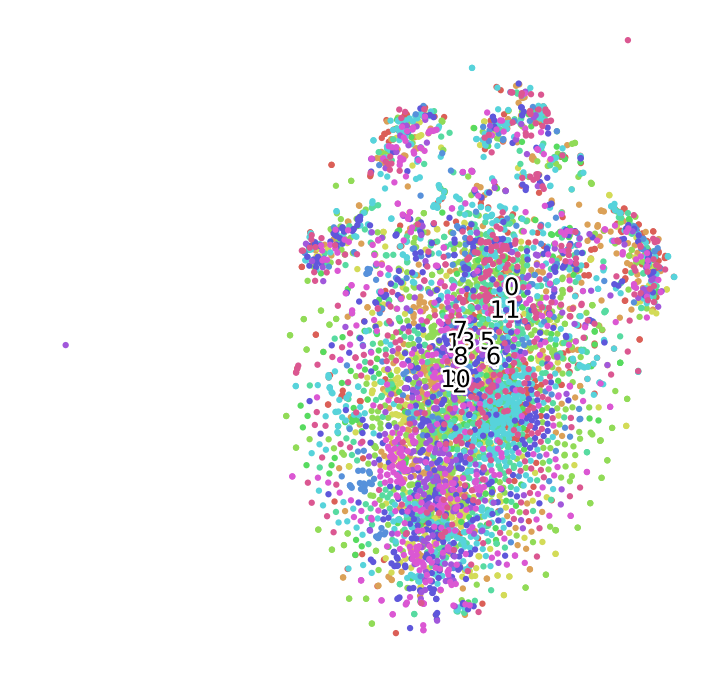

In [18]:
import matplotlib.patheffects as PathEffects

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 12))

    # We create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(12):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts
scatter(X_embedded, Y_embedded)
plt.savefig('./sources/tsne-generated.png', dpi=120)

In [19]:
def is_identical(Data):
    identical = dict()
    file_count = len(train_df)
    for i in tqdm(range(file_count)):
        duplicate = []
        for j in range(file_count):
            if i == j:
                continue
            else:
                a = cv2.absdiff(Data[i], Data[j])
                if a.sum() == 0 and j not in identical.keys:
                    duplicate.append(j)
        if len(duplicate) != 0:
            identical[i] = duplicate
         
    return identical
# identical = is_identical(X_Data)
# print (identical)


{'1592': [1597, 1747], '4448': [4627]}


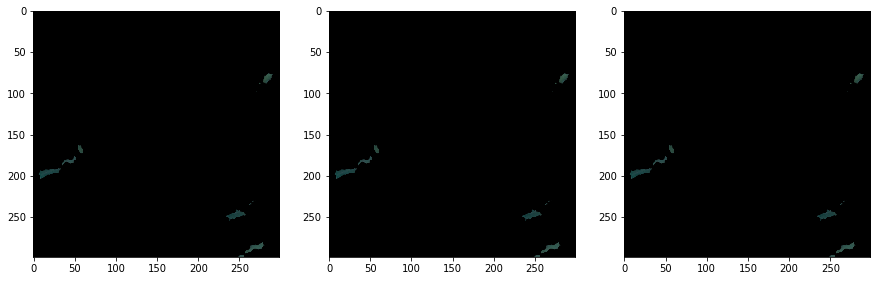

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(X_Data[1592])
axs[1].imshow(X_Data[1597])
axs[2].imshow(X_Data[1747])

In [21]:
print (train_df['category'][1592])
print (train_df['category'][1597])
print (train_df['category'][1747])

Common wheat
Common wheat
Common wheat


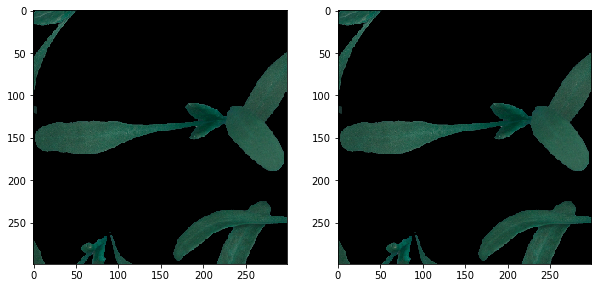

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(X_Data[4448])
axs[1].imshow(X_Data[4627])

In [23]:
print (train_df['category'][4448])
print (train_df['category'][4627])

Sugar beet
Sugar beet


In [19]:
# Create Kaggle Required Metric fscore
# Credit to Kaggler - AshishPatel (https://www.kaggle.com/ashishpatel26/plant-seed-classification-using-vgg16)
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [24]:
# img = cv2.imread('plant_seedling_benchmark.png')
# show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
# plt.figure(figsize=(22,10))
# plt.imshow(show_img)
# plt.show()

### Pretrained Model Benchmark Table
![](./sources/plant_seedling_benchmark.png)

In [20]:
# Inception_V3 Model
img_rows, img_cols, img_depths = 299, 299, 3
def Inception_V3(img_rows, img_cols, img_depths):
    base_model = InceptionV3(include_top=False, pooling='avg', weights="imagenet")
    model = base_model.output
    # Add a new Dense layer to fully connect the node
    model = Dense(4096, activation='relu')(model)
    # Add a new Dense layer to output 12 classes
    # Initialize the weight with Xavier Normal Initialization
    prediction = Dense(12, activation='softmax', kernel_initializer='glorot_normal')(model)
    model = Model(base_model.input, prediction)

    print('model loading finished succesfully')    

    return model

# def Inception_V3(img_rows, img_cols,img_depths ):
#     model = Sequential()
#     model.add(InceptionV3(include_top=False, pooling='avg', weights="imagenet"))
#     model.add(Dense(12, activation='softmax', kernel_initializer='glorot_normal'))
    
#     # Using SGD as an optimizer with learning rate=0.001 and decay = 0.000001
#     learning_rate = 0.005
#     decay_rate = 0.0001
#     sgd = SGD(lr=learning_rate, decay=decay_rate, momentum=0.9, nesterov=True)
#     adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay_rate)
#     # Compile model with custom fscore metric 
#     model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', fscore])
#     print('model loading and compilation finished succesfully')    

#     return model

Inception_Model = Inception_V3(img_rows, img_cols, img_depths)
Inception_Model.summary()

model loading finished succesfully
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________

In [21]:
# Using SGD as an optimizer with learning rate=0.001 and decay = 0.0001
learning_rate = 0.0025
decay_rate = 0.0001
sgd = SGD(lr=learning_rate, decay=decay_rate, momentum=0.9, nesterov=True)
adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay_rate)
lr_metric = get_lr_metric(sgd)
# Only train the top 2 block
# for layer in Inception_Model.layers[:249]:
#     layer.trainable = False
# for layer in Inception_Model.layers[249:]:
#     layer.trainable = True
    
# Compile model with custom fscore metric 
Inception_Model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', fscore, lr_metric])
print('model compilation finished succesfully')    


model compilation finished succesfully


In [71]:
# Step Decay Function
sd=[]
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

def step_decay(losses):
    print (history)
    if float(2*np.sqrt(np.array(history.losses[-1])))<0.3:
        lrate=0.01*1/(1+0.1*len(history.losses))
        momentum=0.8
        decay_rate=2e-6
        return lrate
    else:
        lrate=0.1
        return lrate
        

In [ ]:
print (X_train.shape)
print (Y_train.shape)

epochs = 20
batch_size = 32
start = time.time()
# for epoch in epochs:
#     for batch in batch_size:
checkpointer = ModelCheckpoint(filepath="./saved_models/InceptionV3_mixed_sgd_25e4lr_"+"epochs_"+ str(epochs) + "-batch_size_"+ str(batch_size) +"-weights-best.hdf5", 
                                monitor = "val_acc", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=4, verbose=0, mode='auto', baseline=None)
history = History()

learningratesch = LearningRateScheduler(step_decay)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=0.0001)

training_log = CSVLogger('./training_log/InceptionV3_mixed_sgd_25e4lr_', separator=',', append=False)

Inception_Model.fit(X_train, Y_train, validation_data= (X_valid, Y_valid), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, earlystopper, history, lr_reduce, training_log, learningratesch], verbose=1)
        
end = time.time()
print (end-start)

In [24]:
print (history.history)

{}


In [25]:
import tensorflow as tf
valid_pred = Inception_Model.predict(X_valid, batch_size=32, verbose=1)
top_values, top_indices = K.get_session().run(tf.nn.top_k(valid_pred, k=5))
print (top_indices)

1874/1874 [==============================] - 23s 12ms/step
[[ 4  9  8 10  7]
 [11  1  0  9  7]
 [ 4  0  6  7  1]
 ...
 [ 5 11  4  7  3]
 [ 7 11  3 10  1]
 [11  0  6  7  4]]


In [26]:
def calculate_top_k():
    positive = 0
    for i in tqdm(range(len(Y_valid))):
        label = np.argmax(Y_valid[i])
        if label in top_indices[i]:
            positive += 1
    
    top_k_acc = positive/len(Y_valid)
    return top_k_acc
        
top_k_acc = calculate_top_k()
print (top_k_acc)


0.9989327641408752


In [34]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

start = time.time()
def synthesize_training_data():
    input_size = 299
    for cat in tqdm(categories):
        # Create synthetic data directory
        if not os.path.exists('./data_arg/' + cat):
            os.makedirs('./data_arg/' + cat)
        for file in os.listdir(os.path.join(train_dir, cat)):
            img = cv2.imread('./train/' + cat + "/" +file)
            img = cv2.resize(img, (input_size,input_size))
            img = img.reshape((1,) + img.shape)
            image_gen.flow(img, batch_size=2,save_to_dir='data_arg/' + cat, save_prefix='syn', save_format='png')

        print ("Synthesising "+cat+" data done")
# synthesize_training_data()
end = time.time()
print (end-start)


0.00022912025451660156


In [27]:
# Save Model history to json file
import json

hist = Inception_Model.history.history
del hist['lr']
json = json.dumps(hist)
f = open("./saved_model_history/inceptionV3_sgd_synthetic_masked_25e4lr_1e4dc_1e8f_1e4mlr_20e_32b.json","w")
f.write(json)
f.close()

In [29]:
def reading_testing_data():
    input_size = 299
    X_test = np.zeros((len(test_df), input_size, input_size, 3), dtype='float32')
    for i in tqdm(range(len(test_df))):
        img = cv2.imread(test_df['file'][i])
        img = create_segmented_image(img)
        img = cv2.resize(img, (input_size,input_size))
        X_test[i] = img/255.
    print('Train Images shape: {} size: {:,}'.format(X_test.shape, X_test.size))
    
    return X_test

X_test = reading_testing_data()
print (X_test.shape)


Train Images shape: (794, 299, 299, 3) size: 212,953,182
(794, 299, 299, 3)


In [31]:
# Predict it on our Test set and print out some results
Inception_Model.load_weights('./saved_models/InceptionV3_mixed_sgd_25e4lr_epochs_20-batch_size_32-weights-best.hdf5', by_name=True)
test_result = Inception_Model.predict(X_test, batch_size=32, verbose=1)
print(test_result)
print (len(test_result))

794/794 [==============================] - 9s 12ms/step
[[1.9877707e-06 4.4033254e-06 9.6562371e-06 ... 1.1465709e-05
  9.9988401e-01 7.7017594e-06]
 [8.4045947e-01 3.8763301e-05 9.4624293e-06 ... 1.6716689e-05
  2.7177683e-05 5.1493975e-05]
 [4.0607986e-07 1.3956447e-06 4.7074541e-06 ... 6.9139656e-07
  1.1700528e-06 9.9981779e-01]
 ...
 [8.2890097e-07 1.5639946e-05 9.9991524e-01 ... 3.3768897e-06
  3.2744238e-06 2.0769089e-06]
 [1.2318766e-06 1.4760234e-06 1.6580150e-05 ... 9.5330870e-07
  3.2748071e-06 1.7582968e-05]
 [9.4131781e-07 1.0638545e-05 3.1958521e-06 ... 4.6039693e-07
  2.2025602e-06 9.9964452e-01]]
794


In [32]:
# Create submission.csv accounting to the required format
submission = pd.DataFrame()
file, species = [], [] 
for i in range(len(test_result)):
    file.append(test_df['file'][i].split('/')[2])
    idx = np.argmax(test_result[i], axis=None, out=None)
    species.append(categories[idx])
submission['file'] = file
submission['species'] = species

submission.to_csv('submission_InceptionV3_sgd_25e4lr_1e4dc_1e8f_1e4mlr_20e_64b_synthetic_masked.csv', sep=',', index= False)

In [32]:
valid_result = Inception_Model.predict(X_valid, batch_size=32, verbose=1)
error_analysis = pd.DataFrame()
valid_pred, valid_true = [], []

for i in range(len(valid_result)):
    idx_pred = np.argmax(valid_result[i], axis=None, out=None)
    idx_true = np.argmax(Y_valid[i], axis=None, out=None)
    valid_pred.append(categories[idx_pred])
    valid_true.append(categories[idx_true])
    
error_analysis['valid_pred'] = valid_pred
error_analysis['valid_true'] = valid_true

error_analysis.to_csv('error_analysis_inceptionV3_sgd_15e4lr_1e4dc_1e8f_1e4mlr_20e_64b_synthetic_masked.csv', sep=',', index= False)


3266/3266 [==============================] - 20s 6ms/step
